# **SESSÃO SPARK E LEITURA DOS DADOS**

## **Sessão Spark**

In [98]:
# Instalar o PySpark
!pip install pyspark

In [99]:
# Iniciar uma sessão spark
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master('local[*]') \
    .appName("analise_nlp") \
    .getOrCreate()

In [100]:
# Montar o drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Leitura de daos**

In [101]:
# baixando o kaggle: https://www.kaggle.com/datasets/luisfredgs/imdb-ptbr
# Leitura dos dados:
# 1. Pela conexão com o google drive #2. Pelo carregamento no colab.(<---)
dados = spark.read.csv("/content/drive/MyDrive/imdb-reviews-pt-br.csv",
                       escape = '\"',
                       inferSchema= True,
                       header = True)

## **Explorando os dados**

Agora que já lemos os dados, vamos explorá-lo entendendo:

* O **tamanho** dos dados
* Os **campos** e o tipo
* O **conteúdo** em cada campo
* A **proporção** das categorias


In [102]:
# O tamanho dos dados
print(f'N° de Linhas:{dados.count()}', f'N° de colunas:{len(dados.columns)}')

N° de Linhas:49459 N° de colunas:4


In [103]:
# campos e tipos
dados.printSchema()

root
 |-- id: integer (nullable = true)
 |-- text_en: string (nullable = true)
 |-- text_pt: string (nullable = true)
 |-- sentiment: string (nullable = true)



In [104]:
# Conteudo
dados.limit(99).show()

+---+--------------------+--------------------+---------+
| id|             text_en|             text_pt|sentiment|
+---+--------------------+--------------------+---------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|
|  2|This is an exampl...|Este é um exemplo...|      neg|
|  3|First of all I ha...|Primeiro de tudo ...|      neg|
|  4|Not even the Beat...|Nem mesmo os Beat...|      neg|
|  5|Brass pictures mo...|Filmes de fotos d...|      neg|
|  6|A funny thing hap...|Uma coisa engraça...|      neg|
|  7|This German horro...|Este filme de ter...|      neg|
|  8|Being a long-time...|Sendo um fã de lo...|      neg|
|  9|"Tokyo Eyes" tell...|"Tokyo Eyes" fala...|      neg|
| 10|Wealthy horse ran...|Fazendeiros ricos...|      neg|
| 11|Cage plays a drun...|Cage interpreta u...|      neg|
| 12|First of all, I w...|Primeiro de tudo,...|      neg|
| 13|So tell me - what...|Então me diga - q...|      neg|
| 14|A big disappointm...|Uma grande decepç...|      neg|
| 15|This film

In [105]:
# Apresentando alguns comentários ditos como negativo ou positivo.
print("Negativo")
dados.filter(dados.id == 190).select("text_pt").show(truncate = False)
print("Positivo")
dados.filter(dados.id == 12427).select("text_pt").show(truncate = False)

Negativo
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|text_pt                                                                                                                 

In [106]:
# Contabilizando os tipos de comentários
dados.groupBy('sentiment').count().show()

+---------+-----+
|sentiment|count|
+---------+-----+
|      pos|24694|
|      neg|24765|
+---------+-----+



# **LIMPANDO E PROCESSANDO OS DADOS**

Para que o computador compreenda nossa linguagem é importante realizar algumas transformações no intuito de faciliar essa compreensão. Para isso, primeiramente podemos realizar a **limpeza dos dados**, que consiste na **remoção de caracteres que não contribui** na distinção dos sentimentos dos comentários dos nossos clientes, podemos citar por exemplos, remover caracteres especiais e espaços no início e fim dos comentários.


Logo após a limpeza de caracteres não relevantes, precisamos realizar o procedimento de **Tokenização**, que consiste no processo de **dividir uma frase** em palavras ou tokens (parte do texto) individuais.

E para finalizar o processamento dos nossos dados, iremos realizar a retirada de **stopwords**, ou seja, aquelas palavras que não auxiliam na classificação ou identificação do texto, em sua maioria são **preposições, artigos, pronomes .**..



In [107]:
#Lembrando como estão nossos dados
dados.limit(10).show()

+---+--------------------+--------------------+---------+
| id|             text_en|             text_pt|sentiment|
+---+--------------------+--------------------+---------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|
|  2|This is an exampl...|Este é um exemplo...|      neg|
|  3|First of all I ha...|Primeiro de tudo ...|      neg|
|  4|Not even the Beat...|Nem mesmo os Beat...|      neg|
|  5|Brass pictures mo...|Filmes de fotos d...|      neg|
|  6|A funny thing hap...|Uma coisa engraça...|      neg|
|  7|This German horro...|Este filme de ter...|      neg|
|  8|Being a long-time...|Sendo um fã de lo...|      neg|
|  9|"Tokyo Eyes" tell...|"Tokyo Eyes" fala...|      neg|
| 10|Wealthy horse ran...|Fazendeiros ricos...|      neg|
+---+--------------------+--------------------+---------+



## **Gráfico WordCloud**

A nuvem de palavras é um recurso visual muito utilizado para entender as palavras mais frequentes de um texto. Aqui usaremos a própria biblioteca do Python `WordCloud`.

A ideia é coletar as palavras usando *list comprehension* e aplicando a função `collect()` em uma [amostra](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.sample.html), já que esta função exige muitos recursos de processamento do spark.


In [108]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# amostra é uma seleção de 10% do conteúdo da coluna text_pt. Um df de 1 coluna (sem índice)
amostra = dados.select('text_pt').sample(fraction = 0.1, seed = 101)
amostra.show(5)

+--------------------+
|             text_pt|
+--------------------+
|"Tokyo Eyes" fala...|
|Cage interpreta u...|
|Então me diga - q...|
|Isto é verdadeira...|
|A presa tem uma h...|
+--------------------+
only showing top 5 rows



In [109]:
# amostra.collect() = [row(text_pt = 'depoimento'), row(text_pt = 'depoimento'), row(text_pt = 'depoimento')]
amostra.collect()

[Row(text_pt='"Tokyo Eyes" fala de uma menina japonesa de 17 anos que cai como um homem sendo caçado por seu irmão mais velho que é um policial. Este filme manco é de cerca de 50% de enchimento e 50% de conversas, conversas e mais conversas. Você verá o elenco estelar de menos de três pessoas enquanto eles conversam no ônibus, conversam e jogam videogames, conversam e cortam o cabelo, conversam e andam e andam e conversam, conversam no celular, passam o tempo conversando etc. enquanto você lê legendas esperando que algo aconteça. O fino fio de uma história não é suficiente para sustentar um filme com baixo valor de produção final, um elenco escasso, e sem ação, sem romance, sem sexo ou nudez, sem drama pesado ... apenas incessante yadayadayadaing. C-'),
 Row(text_pt='Cage interpreta um bêbado e é elogiado pela crítica. Elizabeth Shue Na verdade, tem que fazer um amor com a parte mais desprezível e superestimada de estrume em Hollywood. Eu literalmente vomitei enquanto assistia a esse f

In [110]:
# lista_toda_amostra é um array de todos os depoimentos da coluna text_pt separados por vírgula
# para cada linha de amostra.collect(), adiciona o conteúdo da coluna text_pt
lista_toda_amostra = [row['text_pt'] for row in amostra.collect()]

lista_toda_amostra

['"Tokyo Eyes" fala de uma menina japonesa de 17 anos que cai como um homem sendo caçado por seu irmão mais velho que é um policial. Este filme manco é de cerca de 50% de enchimento e 50% de conversas, conversas e mais conversas. Você verá o elenco estelar de menos de três pessoas enquanto eles conversam no ônibus, conversam e jogam videogames, conversam e cortam o cabelo, conversam e andam e andam e conversam, conversam no celular, passam o tempo conversando etc. enquanto você lê legendas esperando que algo aconteça. O fino fio de uma história não é suficiente para sustentar um filme com baixo valor de produção final, um elenco escasso, e sem ação, sem romance, sem sexo ou nudez, sem drama pesado ... apenas incessante yadayadayadaing. C-',
 'Cage interpreta um bêbado e é elogiado pela crítica. Elizabeth Shue Na verdade, tem que fazer um amor com a parte mais desprezível e superestimada de estrume em Hollywood. Eu literalmente vomitei enquanto assistia a esse filme. Claro que tive grip

In [111]:
# configurando o recurso visual wordCloud
wordcloud = WordCloud(background_color = 'white',
                      width = 1000,
                      height = 600,
                      collocations = False,
                      prefer_horizontal = 1).generate(str(tudo))

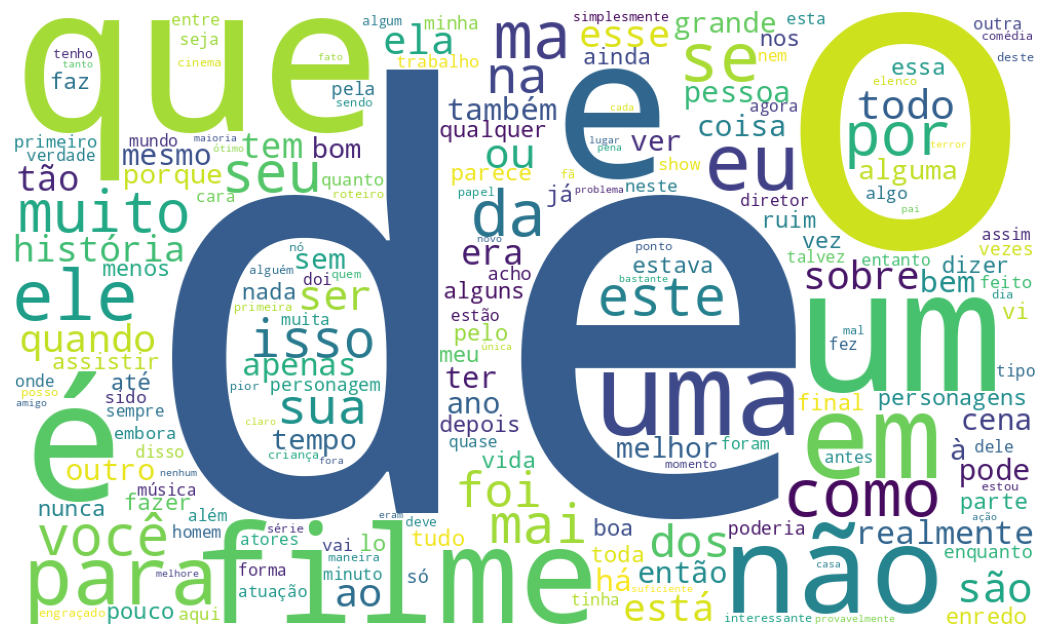

In [112]:
# configurando especificidades do gráfico usando matplotlib
plt.figure(figsize=(20,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## **Remover caracteres especiais**

In [113]:
# remover esses tipos de caracteres
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [114]:
import pyspark.sql.functions as f

# com a coluna texto_regex (que será adicionada),
# substiruir na coluna text_en, as expressões regulares (caracteres especiais), por ""
dados = dados.withColumn("texto_regex", f.regexp_replace("text_en", "[\$#,\"!%&'()*+-./:;<=>?@^_`´{|}~\\\\]", ""))
dados.show(5)

+---+--------------------+--------------------+---------+--------------------+
| id|             text_en|             text_pt|sentiment|         texto_regex|
+---+--------------------+--------------------+---------+--------------------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|Once again Mr Cos...|
|  2|This is an exampl...|Este é um exemplo...|      neg|This is an exampl...|
|  3|First of all I ha...|Primeiro de tudo ...|      neg|First of all I ha...|
|  4|Not even the Beat...|Nem mesmo os Beat...|      neg|Not even the Beat...|
|  5|Brass pictures mo...|Filmes de fotos d...|      neg|Brass pictures mo...|
+---+--------------------+--------------------+---------+--------------------+
only showing top 5 rows



## **Remover espaços em branco desnecessários**

In [115]:
# poderiamos usar regex, mas vamos usar o trim
# com a coluna texto_limpo (que será adicionada), recortar espaços em branco da coluna texto_regex
dados_limpo = dados.withColumn("texto_limpo", f.trim(dados.texto_regex) )
dados_limpo.show(5)

+---+--------------------+--------------------+---------+--------------------+--------------------+
| id|             text_en|             text_pt|sentiment|         texto_regex|         texto_limpo|
+---+--------------------+--------------------+---------+--------------------+--------------------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|Once again Mr Cos...|Once again Mr Cos...|
|  2|This is an exampl...|Este é um exemplo...|      neg|This is an exampl...|This is an exampl...|
|  3|First of all I ha...|Primeiro de tudo ...|      neg|First of all I ha...|First of all I ha...|
|  4|Not even the Beat...|Nem mesmo os Beat...|      neg|Not even the Beat...|Not even the Beat...|
|  5|Brass pictures mo...|Filmes de fotos d...|      neg|Brass pictures mo...|Brass pictures mo...|
+---+--------------------+--------------------+---------+--------------------+--------------------+
only showing top 5 rows



## **Tokenização**
divisão das frases em tokens

In [116]:
from pyspark.ml.feature import Tokenizer

# gerador de tokens. Pega a coluna texto_limpo e transforma na coluna tokens
tokenizer = Tokenizer(inputCol = "texto_limpo", outputCol = "tokens")
# aplicar o gerador de tokens ao df
dados_token = tokenizer.transform(dados_limpo)

In [117]:
dados_token.select("texto_limpo", "tokens").show(5)

+--------------------+--------------------+
|         texto_limpo|              tokens|
+--------------------+--------------------+
|Once again Mr Cos...|[once, again, mr,...|
|This is an exampl...|[this, is, an, ex...|
|First of all I ha...|[first, of, all, ...|
|Not even the Beat...|[not, even, the, ...|
|Brass pictures mo...|[brass, pictures,...|
+--------------------+--------------------+
only showing top 5 rows



In [118]:
# Contagem de tokens por comentário (linha)

from pyspark.sql.types import IntegerType

# countTokens é uma função lambda onde a variável tokens é contada por len() e deve ser transformada para o tipo inteiro
countTokens = f.udf(lambda tokens: len(tokens), IntegerType())

# selecionar 2 colunas do df
# com a coluna freq_tokens (que será adicionada), conta os tokens das linhas recebendo a coluna tokens do df
dados_token.select("texto_limpo", "tokens").withColumn("Freq_tokens", countTokens(f.col("tokens"))).show(5)

+--------------------+--------------------+-----------+
|         texto_limpo|              tokens|Freq_tokens|
+--------------------+--------------------+-----------+
|Once again Mr Cos...|[once, again, mr,...|        168|
|This is an exampl...|[this, is, an, ex...|        232|
|First of all I ha...|[first, of, all, ...|        215|
|Not even the Beat...|[not, even, the, ...|        308|
|Brass pictures mo...|[brass, pictures,...|        238|
+--------------------+--------------------+-----------+
only showing top 5 rows



## **StopWords**
remoção de ruídos (palavras vazias, insignificantes)

Podemos usar o [`StopWordsRemover()`](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.StopWordsRemover.html) nativo do spark, ou o [`stopwords()`](https://openbase.com/js/nltk-stopwords/documentation) da biblioteca nltk do Python. Dentre muitas linguagens, ambas bibliotecas dão suporte para o português.

Vamos começar com um **exemplo pequeno** e depois aplicar em nossos dados.

In [119]:
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords

# lista de stopWords do NLTK
stop_nltk = stopwords.words("portuguese")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [120]:
from pyspark.ml.feature import StopWordsRemover

# lista de stopWords em português
stop_pyspark = StopWordsRemover.loadDefaultStopWords("portuguese")

In [121]:
# removedor de stopwords recebe coluna tokens e cria coluna tokens_limpo
# tokens_limpo é os depoimentos filtrados recebendo uma lista de stopwords como referência
removedor_stop = StopWordsRemover(inputCol = "tokens", outputCol = "tokens_limpo", stopWords= stop_nltk)

# aplicar o removedor de stopwords à um novo df
dados_feature = removedor_stop.transform(dados_token)

In [122]:
# ----------------------------------------------------------------

# tokens_limpo é os depoimentos filtrados recebendo uma lista de stopwords como referência
removedor_stopwords = StopWordsRemover(inputCol = "tokens_limpo", outputCol = "tokens_limpo", stopWords= stop_pyspark)

# aplicar o removedor de stopwords à um novo df
dados_feature = removedor_stop.transform(dados_token)

In [123]:
dados_feature.show(5, False)
#Once  again  Mr  Costner  has  dragged  out  a  movie  for  far  longer  than  necessary  -- texto_limpo
#once, again, mr, costner, has, dragged, out, a, movie, for, far, longer, than, necessary, -- tokens
#once, again, mr, costner, has, dragged, out,    movie,      far, longer, than, necessary  -- tokens_limpo


+---+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [124]:
# Contagem de tokens antes e depois do stopwords.
dados_feature.select("tokens", "tokens_limpo")\
          .withColumn("Freq_tokens", countTokens(f.col("tokens")))\
          .withColumn("Freq_tokens_limpo",  countTokens(f.col("tokens_limpo"))).show(5)

+--------------------+--------------------+-----------+-----------------+
|              tokens|        tokens_limpo|Freq_tokens|Freq_tokens_limpo|
+--------------------+--------------------+-----------+-----------------+
|[once, again, mr,...|[once, again, mr,...|        168|              159|
|[this, is, an, ex...|[this, is, an, ex...|        232|              225|
|[first, of, all, ...|[first, of, all, ...|        215|              203|
|[not, even, the, ...|[not, even, the, ...|        308|              295|
|[brass, pictures,...|[brass, pictures,...|        238|              230|
+--------------------+--------------------+-----------+-----------------+
only showing top 5 rows



## **Vetorização**

A vetorização dos dados permite transformá-los da linguagem humana e não estruturada para uma maneira mais compreensível ao computador, ou seja, **codificando em números**, sendo possível assim associar cada um dos textos a um sentido e significado delimitados.


O **Bag of Words**, ou sacola de palavras em português, é uma lista que contém todas as palavras que estão nos textos de maneira não repetida e tem papel importante para **identificar as palavras mais recorrentes** e entender se elas agregam algum sentimento.


Aqui no spark o bag of words não é representado por uma matriz do vocabulário como no python, e sim com uma estrutura específica que cria uma **estrutura especifica** que faciliar a compreensão nos modelos.

Alternativas para vetorização: matriz_esparsa, countvectorizer, Hashing TF...



### **CountVector**
Frequência das palavras em cada depoimento

Para cada observação é gerado vetor com a seguinte estrutura: \\
 `[número de features(palavras), [cód. (indice) das palavras na ordem do vocabulário],[frequência de cada palavra]]`

###### [CountVector](https://spark.apache.org/docs/3.2.1/api/python/reference/api/pyspark.ml.feature.CountVectorizer.html)

In [125]:
from pyspark.ml.feature import CountVectorizer

# gerador de dados vetorizados
countvec = CountVectorizer(inputCol="tokens_limpo", outputCol="CountVec")
# modelo ajustado ao df
model = countvec.fit(dados_feature)
# aplicação do modelo em um novo df
dados_feature_vec = model.transform(dados_feature)

# Array de palavras do vocabulario do modelo
model.vocabulary

['the',
 'and',
 'of',
 'to',
 'is',
 'in',
 'it',
 'i',
 'this',
 'that',
 'was',
 'with',
 'movie',
 'but',
 'film',
 'on',
 'you',
 'not',
 'are',
 'his',
 'have',
 'be',
 'one',
 'he',
 'its',
 'at',
 'all',
 'by',
 'an',
 'they',
 '',
 'who',
 'from',
 'like',
 'so',
 'just',
 'or',
 'about',
 'her',
 'has',
 'out',
 'if',
 'some',
 'what',
 'there',
 'good',
 'very',
 'more',
 'when',
 'my',
 'even',
 'up',
 'would',
 'she',
 'time',
 'really',
 'only',
 'which',
 'see',
 'their',
 'story',
 'were',
 'had',
 'can',
 'than',
 'much',
 'well',
 'we',
 'get',
 'been',
 'great',
 'will',
 'bad',
 'other',
 'people',
 'into',
 'because',
 'also',
 'how',
 'most',
 'first',
 'dont',
 'him',
 'movies',
 'made',
 'make',
 'then',
 'films',
 'could',
 'them',
 'way',
 'any',
 'too',
 'characters',
 'think',
 'after',
 'watch',
 'seen',
 'many',
 'being',
 'two',
 'never',
 'character',
 'acting',
 'love',
 'plot',
 'little',
 'did',
 'best',
 'know',
 'show',
 'where',
 'ever',
 'life',
 

In [126]:
dados_feature_vec.select('tokens_limpo','CountVec').show(5, False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### **Hashing TF**
Alternativa ao CountVector, porém limitamos o número de palavras contabilizadas.


###### [Hashing TF](https://spark.apache.org/docs/3.2.1/api/python/reference/api/pyspark.ml.feature.HashingTF.html)



In [127]:
from pyspark.ml.feature import HashingTF

# gerador de dados vetorizados com limitação
hashingTF = HashingTF(inputCol="tokens_limpo", outputCol="hashingTF", numFeatures=1000)

# aplicação do modelo em um novo df
dados_feature_HTF = hashingTF.transform(dados_feature_vec)




In [128]:
dados_feature_HTF.select('tokens_limpo', 'hashingTF').show(5)

+--------------------+--------------------+
|        tokens_limpo|           hashingTF|
+--------------------+--------------------+
|[once, again, mr,...|(1000,[10,17,21,3...|
|[this, is, an, ex...|(1000,[0,3,11,12,...|
|[first, of, all, ...|(1000,[1,7,17,33,...|
|[not, even, the, ...|(1000,[0,3,10,12,...|
|[brass, pictures,...|(1000,[3,6,7,11,1...|
+--------------------+--------------------+
only showing top 5 rows



### **TF - IDF**
Idem ao TF, porém gera pesos para cada palavra a partir da predominância (frequência).

In [129]:
from pyspark.ml.feature import IDF

# gerador de dados vetorizados com limitação e pesos (passo final para uso em machine learning)
idf = IDF(inputCol="hashingTF", outputCol="features")

# modelo ajustado ao df
idfModel = idf.fit(dados_feature_HTF)

# aplicação do modelo em um novo df (df final para uso em machine learning)
dados_feature_IDF = idfModel.transform(dados_feature_HTF)


In [130]:
dados_feature_IDF.select('tokens_limpo', 'features').show(5)

+--------------------+--------------------+
|        tokens_limpo|            features|
+--------------------+--------------------+
|[once, again, mr,...|(1000,[10,17,21,3...|
|[this, is, an, ex...|(1000,[0,3,11,12,...|
|[first, of, all, ...|(1000,[1,7,17,33,...|
|[not, even, the, ...|(1000,[0,3,10,12,...|
|[brass, pictures,...|(1000,[3,6,7,11,1...|
+--------------------+--------------------+
only showing top 5 rows



## **Codificando**: Variável Resposta.
Lembrando que ensinaremos que todas essas palavras estarão associadas ao sentimento do depoimento, positivo ou negativo, entretando precisamos codificar `neg` e `pos` para 0 e 1 e podemos usar o `StringIndexer`



In [131]:
# Nossos dados estão em texto. É preciso converter para número
dados_feature_IDF.groupBy('sentiment').count().show()

+---------+-----+
|sentiment|count|
+---------+-----+
|      pos|24694|
|      neg|24765|
+---------+-----+



In [140]:
from pyspark.ml.feature import StringIndexer

# gerador de índice para strings. Substitui a categoria pos e neg por 0 e 1
stringindexer = StringIndexer(inputCol="sentiment", outputCol="label")

# Ajusta o modelo com os dados originais e aplica o modelo nos dados originais(df)
dados_limpo = stringindexer.fit(dados_limpo).transform(dados_limpo)



In [141]:
# Quem é 0 e quem é 1?
dados_limpo.groupBy(['sentiment','label']).count().show()

+---------+-----+-----+
|sentiment|label|count|
+---------+-----+-----+
|      pos|  1.0|24694|
|      neg|  0.0|24765|
+---------+-----+-----+



In [134]:
dados_limpo.show(5)

+---+--------------------+--------------------+---------+--------------------+--------------------+--------------------+-----+
| id|             text_en|             text_pt|sentiment|         texto_regex|         texto_limpo|              tokens|label|
+---+--------------------+--------------------+---------+--------------------+--------------------+--------------------+-----+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|Once again Mr Cos...|Once again Mr Cos...|[once, again, mr,...|  0.0|
|  2|This is an exampl...|Este é um exemplo...|      neg|This is an exampl...|This is an exampl...|[this, is, an, ex...|  0.0|
|  3|First of all I ha...|Primeiro de tudo ...|      neg|First of all I ha...|First of all I ha...|[first, of, all, ...|  0.0|
|  4|Not even the Beat...|Nem mesmo os Beat...|      neg|Not even the Beat...|Not even the Beat...|[not, even, the, ...|  0.0|
|  5|Brass pictures mo...|Filmes de fotos d...|      neg|Brass pictures mo...|Brass pictures mo...|[brass, pict

## **Pipeline**: Transformação dos dados



In [143]:
# automatização do trabalho
from pyspark.ml import Pipeline

# gerador de tokens
tokenizer = Tokenizer(inputCol="texto_limpo", outputCol="tokens")
# removedor de StopWords
stopwords = StopWordsRemover(inputCol="tokens", outputCol="tokens_limpo")
# contador de tokens limitado a 1000 palavras
hashingTF = HashingTF(inputCol="tokens_limpo", outputCol="HTF", numFeatures=1000)
# avaliador de peso dos tokens (dá nota)
idf = IDF(inputCol="HTF", outputCol="features")

## inputCol=stopwords.getOutputCol()  == outputCol="tokens_limpo" ##

In [144]:
# Criação do pipeline que irá automatizar as tarefas
pipeline = Pipeline(stages = [tokenizer,stopwords, hashingTF, idf])

In [145]:
# ajusta o modelo aos dados originais e aplica o modelo aos dados originais
dados_transformados = pipeline.fit(dados_limpo).transform(dados_limpo)

In [146]:
dados_transformados.show(5)

+---+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
| id|             text_en|             text_pt|sentiment|         texto_regex|         texto_limpo|label|              tokens|        tokens_limpo|                 HTF|            features|
+---+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|Once again Mr Cos...|Once again Mr Cos...|  0.0|[once, again, mr,...|[mr, costner, dra...|(1000,[10,21,34,4...|(1000,[10,21,34,4...|
|  2|This is an exampl...|Este é um exemplo...|      neg|This is an exampl...|This is an exampl...|  0.0|[this, is, an, ex...|[example, majorit...|(1000,[0,3,11,12,...|(1000,[0,3,11,12,...|
|  3|First of all I ha...|Primeiro de tudo ...|   

# **MODELO DE CLASSIFICAÇÃO**

Nosso objetivo é consguir identificar um comentário negativo ou positivo, para isso precisamos criar um modelo em que o computador consiga classificar os depoimentos. Agora que já processamos nossos dados podemos construir um **modelo de classificação**, veja alguma opções:

* Regressão Logística
* Árvore de Decisão
* Florestas Aleatórias
* GX boost
* entre outros...

Para testar nossos dados usaremos todos os procedimentos realizados em Limpeza e processamento dos dados e a vetorização que estabelece pesos para as palavras construidas a partir do TF-IDF.





In [147]:
# Entendendo nossos dados
featureDF = dados_transformados.select(['features', 'label'])


In [148]:
featureDF.show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(1000,[10,21,34,4...|  0.0|
|(1000,[0,3,11,12,...|  0.0|
|(1000,[1,7,33,38,...|  0.0|
|(1000,[0,3,10,12,...|  0.0|
|(1000,[3,6,7,11,3...|  0.0|
+--------------------+-----+
only showing top 5 rows



In [149]:
# tipo lido pelo modelo.
featureDF.printSchema()

root
 |-- features: vector (nullable = true)
 |-- label: double (nullable = false)



## **Criar um modelo de classificação de árvore de decisão**

In [151]:
from pyspark.ml.classification import DecisionTreeClassifier

# modelo de arvore de decisão recebe colunas features e label e profundidade
dt = DecisionTreeClassifier(featuresCol='features', labelCol='label', maxDepth=10)

# inserir o modelo de arvore de decisão às tarefas do pipeline
pipeline = Pipeline(stages = [tokenizer,stopwords, hashingTF, idf, dt])

### **Amostra e Treino**

In [154]:
# separando os dados
train, test = dados_limpo.randomSplit([0.7, 0.3], seed = 101)

In [155]:
# ajustar o pipeline aos dados de treino
dt_model = pipeline.fit(train)

In [156]:
# aplicar o modelo ajustado aos dados de teste
predictions = dt_model.transform(test)

In [157]:
predictions.show(5)

+---+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+---------------+--------------------+----------+
| id|             text_en|             text_pt|sentiment|         texto_regex|         texto_limpo|label|              tokens|        tokens_limpo|                 HTF|            features|  rawPrediction|         probability|prediction|
+---+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+---------------+--------------------+----------+
|  5|Brass pictures mo...|Filmes de fotos d...|      neg|Brass pictures mo...|Brass pictures mo...|  0.0|[brass, pictures,...|[brass, pictures,...|(1000,[3,6,7,11,3...|(1000,[3,6,7,11,3...| [366.0,1112.0]|[0.24763193504736...|       1.0|
|  6|A funny thing hap...|Uma coisa engraça...| 

### **Teste e Métricas**


In [158]:
predictions.select(['label','prediction']).show()

+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 20 rows



In [159]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# avaliador de métricas de classificação - metrica acurácia
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')

# aplicar o avaliador aos dados vindos do pipeline(que inclue o modelo de arvore de decisão)
acuracia = evaluator.evaluate(predictions)

In [160]:
# porcentagem de acerto
print("Acuracia = %s" % (acuracia))

Acuracia = 0.6700404858299596


### **Testar novas frases para observar a resposta do modelo**

In [161]:
# Este é sem dúvida o pior filme que já vi, odiei a atuação dos atores.
# Adorei o filme, excelente atuação!

In [162]:
nova_base = spark.createDataFrame([
    (1, "This is without doubt the worst movie i have ever seen, I hated the acting of the actors."),
    (0, "I loved the movie, excellent acting!"),
], ["id", "texto_limpo"])

In [163]:
nova_class = dt_model.transform(nova_base)

In [164]:
nova_class.show()

+---+--------------------+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+----------+
| id|         texto_limpo|              tokens|        tokens_limpo|                 HTF|            features|rawPrediction|         probability|prediction|
+---+--------------------+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+----------+
|  1|This is without d...|[this, is, withou...|[without, doubt, ...|(1000,[35,43,269,...|(1000,[35,43,269,...|  [18.0,10.0]|[0.64285714285714...|       0.0|
|  0|I loved the movie...|[i, loved, the, m...|[loved, movie,, e...|(1000,[185,543,73...|(1000,[185,543,73...|[156.0,774.0]|[0.16774193548387...|       1.0|
+---+--------------------+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+----------+

